# Imports

In [1]:
import os
import torch 

from auto_circuit.data import load_datasets_from_json
from auto_circuit.experiment_utils import load_tl_model
from auto_circuit.prune_algos.mask_gradient import mask_gradient_prune_scores
from auto_circuit.types import PruneScores
from auto_circuit.utils.graph_utils import patchable_model, patch_mode
from auto_circuit.utils.misc import repo_path_to_abs_path
from auto_circuit.visualize import draw_seq_graph
from auto_circuit.utils.ablation_activations import src_ablations
from auto_circuit.types import AblationType

from auto_circuit.utils.tensor_ops import (
    correct_answer_proportion, 
    correct_answer_greater_than_incorrect_proportion, 
    batch_avg_answer_diff, 
    batch_answer_diff_percents, 
    correct_answer_greater_than_incorrect_proportion
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

/home/iustin/.conda/envs/mech-interp-toolkit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# AutoCircuit algorithm

The [auto_circuit](https://github.com/UFO-101/auto-circuit) library is a companion of the paper [Transformer Circuit Faithfulness Metrics Are Not Robust](https://arxiv.org/pdf/2407.08734) by Miller et al. (2024). It introduces an automatic circuit discovery algorithm called [**Edge Patching**](https://www.lesswrong.com/posts/caZ3yR5GnzbZe2yJ3/how-to-do-patching-fast), which is an extension of the Attribution Patching algorithm to work at **edge granularity**—that is, it measures how the signal that flows *from one module of the Transformer into another* (e.g. `attn_out → mlp_in`). We compute an attribution score of an edge (see in `auto_circuit.prune_algos.mask_gradient_prune_scores`) by corrupting the output of the sender (or source) node `attn_out` and calculating the gradient of the receiver (or destination) node `mlp_in`. For a single edge $e$ we define the **edge-attribution score**: 

$$
\mathrm{attr}(e)\;=\;
\Bigl\langle
\underbrace{\frac{\partial \text{logit}}{\partial x_e}}_{\text{local sensitivity}},
\;
\underbrace{x_e^{\text{corr}}-x_e^{\text{clean}}}_{\text{patch difference}}
\Bigr\rangle ,
\tag{1}
$$

where  

* $x_e^{\text{clean}}$ is the activation on that edge clean forward pass,  
* $x_e^{\text{corr}}$ is the activation in a corrupted forward pass, and  

The attribution score of an edge is a scalar that says how much a specific connection (edge) helps or hurts the model’s answer—computed by taking the output-sensitivity (the gradient) at that edge and multiplying it by the difference between the edge’s corrupted and clean activations.

A **positive** edge-attribution score means restoring the clean activation raises the correct-token logit (the edge is *helpful*); a **negative** value means the edge pushes the model in the wrong (writes in the opposite) direction in the residual stream. For more information on how the edge attribution scores are computed see `auto_circuit.prune_algos.edge_attribution_patching_prune_scores`. 

---------

<details><summary>Edge Patching as a First-Order Taylor series:</summary>

In the paper Attribution Patching Outperforms Automated Circuit Discovery" [(Syed et al. (2023))](https://arxiv.org/abs/2310.10348), the authors introduced Edge Attribution Patching as a faster and better alternative to the ACDC algorithm [(Conmy et al., (2023)](https://arxiv.org/pdf/2304.14997) (which applies an iterative Path Patching algorithm by recursively removing edges in a top-down manner, starting from the furthest layers to the closest) which requires two forward passes per edge removal.

Let $L\bigl(x_e\bigr)$ be the scalar loss (or any monotone score of interest; Logit Diff or MSE) seen as a function of the edge activation $x_e$ while all other activations are kept at their corrupted values.  
Writing  
$$
\Delta x_e \;=\; x_e^{\text{corr}}-x_e^{\text{clean}},
$$
the **patched** loss is  
$$
\;L\bigl(x_e^{\text{clean}}+\Delta x_e\bigr).
$$


For small perturbations $\Delta x_e$ we expand $L$ around the clean point:

$$
L\bigl(x_e^{\text{clean}}+\Delta x_e\bigr)
=\;
L\bigl(x_e^{\text{clean}}\bigr)
+\;
\bigl\langle
  \nabla_{x_e}L\bigl|_{x_e^{\text{corr}}},
  \Delta x_e
\bigr\rangle
+\;
\mathcal{O}\!\bigl(\|\Delta x_e\|^{2}\bigr).
\tag{2}
$$

The term in angle brackets is exactly Eq. (1), because  
$\nabla_{x_e}L = \tfrac{\partial \text{logit}}{\partial x_e}$ for a logit-difference score.  
Therefore, up to first order,

$$
\boxed{%
\Delta L
\;=\;
L_{\text{corr}}-L_{\text{clean}}
\;\approx\;
\mathrm{attr}(e)
}\;.
$$

Higher-order (quadratic and cubic) terms vanish rapidly when the clean and corrupted activations are similar, which is why gradient × Δactivation is a good proxy for the *exact* causal patch even though it needs only **one** backward pass.

</details>

In [2]:
SAVE = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tl_model = load_tl_model("gpt2", device)

root = os.getcwd()
path = repo_path_to_abs_path(os.path.join(root, 'data/ioi/ioi_vanilla_template_prompts.json'))

train_loader, test_loader = load_datasets_from_json(
    model=tl_model,
    path=path,
    device=device,
    prepend_bos=True,
    batch_size=16,
    train_test_size=(128, 128),
)

auto_model1 = patchable_model(
    tl_model,
    factorized=True,
    slice_output="last_seq",
    separate_qkv=True,
    device=device,
)

attribution_scores1: PruneScores = mask_gradient_prune_scores(
    model=auto_model1,
    dataloader=train_loader,
    official_edges=None,
    grad_function="logit",
    answer_function="avg_diff",
    mask_val=0.0,
)

fig = draw_seq_graph(
    auto_model1, attribution_scores1, score_threshold=3.5, layer_spacing=True, orientation="v"
)
if SAVE:
    fig.write_image(repo_path_to_abs_path("/home/iustin/Round_and_Round_RoPE/auto_circuit_exps/test_last_2l.png"), scale=4)

Loaded pretrained model gpt2 into HookedTransformer


Sample: 0██████████| 1/1 [00:00<00:00,  1.60it/s]


## Ablating Edges in our Circuit

We can furthermore perform an ablation on the edges from the circuit found by the AutoCircuit algorithm. First, we take the attribution scores and compute the importance score of each edge in the circuit:

In [3]:
from src.circuit_discovery.utils import get_real_edges

edges_A, remaining_edges_A = get_real_edges(
    tl_model,
    attribution_scores1,
    score_threshold=3.5,
    print_egdes=True,
    return_edges=True,
)

dict_keys(['blocks.10.hook_q_input', 'blocks.5.hook_v_input', 'blocks.6.hook_q_input', 'blocks.8.hook_q_input', 'blocks.10.hook_mlp_in', 'blocks.9.hook_mlp_in', 'blocks.6.hook_k_input', 'blocks.2.hook_mlp_in', 'blocks.2.hook_v_input', 'blocks.10.hook_k_input', 'blocks.2.hook_k_input', 'blocks.0.hook_k_input', 'blocks.1.hook_q_input', 'blocks.7.hook_k_input', 'blocks.3.hook_q_input', 'blocks.1.hook_k_input', 'blocks.1.hook_v_input', 'blocks.8.hook_mlp_in', 'blocks.7.hook_q_input', 'blocks.10.hook_v_input', 'blocks.3.hook_v_input', 'blocks.11.hook_mlp_in', 'blocks.11.hook_v_input', 'blocks.5.hook_k_input', 'blocks.11.hook_k_input', 'blocks.6.hook_v_input', 'blocks.8.hook_k_input', 'blocks.8.hook_v_input', 'blocks.0.hook_q_input', 'blocks.9.hook_q_input', 'blocks.0.hook_v_input', 'blocks.1.hook_mlp_in', 'blocks.11.hook_resid_post', 'blocks.11.hook_q_input', 'blocks.4.hook_k_input', 'blocks.5.hook_mlp_in', 'blocks.7.hook_v_input', 'blocks.9.hook_v_input', 'blocks.0.hook_mlp_in', 'blocks.5.

Next we can perform Zero Ablation on any edge we want, given that it is a valid key in the `auto_model.edge_dict.values()`. The following takes the top edge by attribution score from the previously computed `edges_A` dictionary and measures the effect of the ablation on the logit difference. We can observe that ablating the all edges *but* the top edge `A9.9 -> Resid End` effectively destroys performance.

In [ ]:
import itertools
auto_model = patchable_model(
    tl_model,
    factorized=True,
    slice_output="last_seq",
    separate_qkv=True,
    kv_caches=(train_loader.kv_cache, test_loader.kv_cache), # this is needed, else patching will not work
    device=device,
)

for batch in test_loader:
    toks = batch.clean
    answers = batch.answers
    wrong_answers = batch.wrong_answers
    answers = [(answers[i], wrong_answers[i]) for i in range(len(answers))]
    answers = torch.tensor(answers, dtype=torch.long)
    answers = answers.to(device)

ablations = src_ablations(auto_model, toks, AblationType.ZERO)

target_edge_str = "A9.9->Resid End" # test if an edge is present
all_edges = list(itertools.chain.from_iterable(auto_model.edge_dict.values()))
all_edge_strs = [str(edge) for edge in edges_A] # these are descending order by attribution score
edge_str = all_edge_strs[0]  # e.g., "MLP 1->Resid End"
found = any(
    edge_str in subdict
    for subdict in auto_model.edge_name_dict.values()
)
assert found, f"Edge '{edge_str}' not found in edge_name_dict"

# patch_edges = [edge for edge in all_edge_strs if edge != target_edge_str]  # patch all edges except the target edge
patch_edges = [edge for edge in all_edge_strs if edge != all_edge_strs[0]]  # patch all edges except the edge with the highest attribution score
print(f"Edges to patch: {patch_edges}")
with patch_mode(auto_model, ablations, patch_edges):
    patched_out = auto_model(toks)

from src.observational.direct_logit_attribution import logits_to_ave_logit_diff
ave_logit_diff = logits_to_ave_logit_diff(patched_out, answer_tokens=answers, per_prompt=False)
print("Average Logit Difference:", ave_logit_diff)

Edges to patch: ['A10.7->A11.10.Q', 'A9.6->Resid End', 'A3.0->A5.9.Q', 'A10.0->Resid End', 'MLP 0->MLP 1', 'Resid Start->A0.10.Q', 'Resid Start->A0.10.K', 'A10.1->Resid End', 'A11.2->Resid End', 'MLP 3->A5.9.Q', 'MLP 0->MLP 3', 'A9.6->A11.10.Q', 'MLP 0->A11.10.K', 'A9.9->A10.7.Q', 'A3.0->MLP 4', 'A11.10->Resid End', 'A9.9->A11.10.Q', 'A10.7->Resid End', 'Resid Start->MLP 0']
Average Logit Difference: tensor(-2.2094, device='cuda:0', grad_fn=<MeanBackward0>)


In [5]:
from auto_circuit.utils.graph_utils import patch_mode
from auto_circuit.utils.ablation_activations import src_ablations
from auto_circuit.types import AblationType
from auto_circuit.utils.tensor_ops import batch_avg_answer_diff

for batch in test_loader:
    toks = batch.clean
    answers = batch.answers
    wrong_answers = batch.wrong_answers
    answers = [(answers[i], wrong_answers[i]) for i in range(len(answers))]
    answers = torch.tensor(answers, dtype=torch.long)
    answers = answers.to(device)

ablations_last = src_ablations(auto_model, toks, AblationType.ZERO)

patch_edges = [
    'A9.9->Resid End',
    'A9.6->Resid End',
    'A10.0->Resid End',
    ]
print(f"Edges to patch: {patch_edges}")

for batch in test_loader:
    clean_out = tl_model(batch.clean)


with patch_mode(auto_model, ablations_last, patch_edges):
    patched_out = auto_model(toks)

proportion_correct_clean = correct_answer_proportion(clean_out[:, -1, :], batch)
print("Proportion of correct answers before patching:", proportion_correct_clean)

correct_answer_greater_than_incorrect_proportion_value_clean = correct_answer_greater_than_incorrect_proportion(clean_out[:, -1, :], batch)
print("Proportion of correct answers greater than incorrect before patching:", correct_answer_greater_than_incorrect_proportion_value_clean)

proportion_correct_abl = correct_answer_proportion(patched_out[:, -1, :], batch)
print("Proportion of correct answers after patching:", proportion_correct_abl)

correct_answer_greater_than_incorrect_proportion_value_abl = correct_answer_greater_than_incorrect_proportion(patched_out[:, -1, :], batch)
print("Proportion of correct answers greater than incorrect after patching:", correct_answer_greater_than_incorrect_proportion_value_abl)

batch_avg_answer_diff_value_clean = batch_avg_answer_diff(clean_out[:, -1, :], batch)
print("Average answer difference full model:", batch_avg_answer_diff_value_clean)

batch_avg_answer_diff_value = batch_avg_answer_diff(patched_out[:, -1, :], batch)
print(f"Average answer difference after patching {patch_edges} edges:", batch_avg_answer_diff_value)

batch_answer_diff_percents_value = batch_answer_diff_percents(patched_out[:, -1, :], clean_out[:, -1, :], batch)
print("Batch answer difference percents after patching:", batch_answer_diff_percents_value)

Edges to patch: ['A9.9->Resid End', 'A9.6->Resid End', 'A10.0->Resid End']
Proportion of correct answers before patching: tensor(1., device='cuda:0')
Proportion of correct answers greater than incorrect before patching: tensor(1., device='cuda:0')
Proportion of correct answers after patching: tensor(0., device='cuda:0')
Proportion of correct answers greater than incorrect after patching: tensor(0.0625, device='cuda:0')
Average answer difference full model: tensor(3.7343, device='cuda:0')
Average answer difference after patching ['A9.9->Resid End', 'A9.6->Resid End', 'A10.0->Resid End'] edges: tensor(-1.5955, device='cuda:0', grad_fn=<MeanBackward0>)
Batch answer difference percents after patching: tensor([ -74.5548,  -29.0329,  -80.4527,  -46.1688,   -9.6145,  -44.7622,
          -4.2016,   74.9101,  -65.5332,  -62.0620,  -19.5097, -125.6204,
         -71.7954,  -51.7030,   -1.5313, -251.8692], device='cuda:0',
       grad_fn=<MulBackward0>)


# Tokenwise AutoCircuit algorithm

Now we extend the AutoCircuit algorithm to a tokenwise circuit ran on the IOI prompts. First make sure that our prompt dataset contains the sequence labels (`seq_labels`) for all tokens and their position (`word_idx`) in the prompt; see `data.ioi.ioi_vanilla_template_prompts`. Patching across differrent positions requires that our prompt is of fixed length and token positions. 

Steps:

1. In <span style='color: yellow'>load_datasets_from_json</span> set <span style="background-color: blue">return_seq_length</span>=True.
2. In <span style='color: yellow'>patchable_model</span>. set <span style="background-color: blue">seq_length</span> to the sequence length of the prompt.
3. In <span style='color: yellow'>draw_seq_graph</span> set <span style="background-color: blue">show_all_seq_pos</span> to True and pass in the sequence labels with `train_loader.seq_labels`. Leave the orientation to horizontal, as vertical is not showing properly the circuit.

If this seems counter-intuitive, a reminder is that the activations in Transformers contain batch and sequence position dimensions (exactly what we set-up before). Also, we compute the logit difference at the final position of the sequence and by then the I/O paths through the model, starting from the first token, considers paths through every subsequent token positions, which is what we see in the figure below.

In [14]:
train_loader, test_loader = load_datasets_from_json(
    model=tl_model,
    path=path,
    device=device,
    prepend_bos=True,
    batch_size=32,
    train_test_size=(256, 256),
    return_seq_length=True,
)

auto_model2 = patchable_model(
    tl_model,
    factorized=True,
    slice_output="last_seq",
    seq_len=test_loader.seq_len,
    separate_qkv=True,
    device=device,
)

attribution_scores2: PruneScores = mask_gradient_prune_scores(
    model=auto_model2,
    dataloader=train_loader,
    official_edges=None,
    grad_function="logit",
    answer_function="avg_diff",
    mask_val=0.0,
)

fig = draw_seq_graph(auto_model2, attribution_scores2, 3.5, show_all_seq_pos=True, seq_labels=train_loader.seq_labels, display_ipython=True, orientation='h')

Sample: 0██████████| 1/1 [00:01<00:00,  1.33s/it]


# ACDC algorithm

The ACDC algorithm recursively removes edges from the furthest layer to the closest that are below a threshold in logit diff, i.e. if the difference between the logit difference of the model with that edge removed and the original logit difference (the full model) is below a fixed threshold $\tau$ then we keep the edge removed and continue to more edges. 

Concretely it applies the Path Patching (check the `ioi_circuit_copy.ipynb` notebook for more info) algorithm iteratively. The intuition is that "If I start from the furthest edge e.g. MLP 11 -> Resid End and I path patch the path `input -> MLP 11 (sender) -> Resid End (receiver) -> logits` and I care about the `MLP 11 -> Resid End` edge I can remove it (that is, set the input of the receiver to either to 0 (**Zero Ablation**) or to the activation on the corrupted run (**Resample Ablation**)) and check the effect this removal has on the logit difference (or we can use the KL divergence of the outputs). If removing it breaks model performance, i.e. the difference in logit diff between this corruption and the uncorrupted model is above my threshold then I keep this edge, or if it is below, then the edge is unimportant and we remove it. We keep removing edges likewise until we reach the beginning of the model, obtaining a minimal subgraph of the model.

ACDC τ=0.0300000██████████| 1/1 [11:28<00:00, 688.58s/it]


Total edges: 32491
Remaining edges: 101


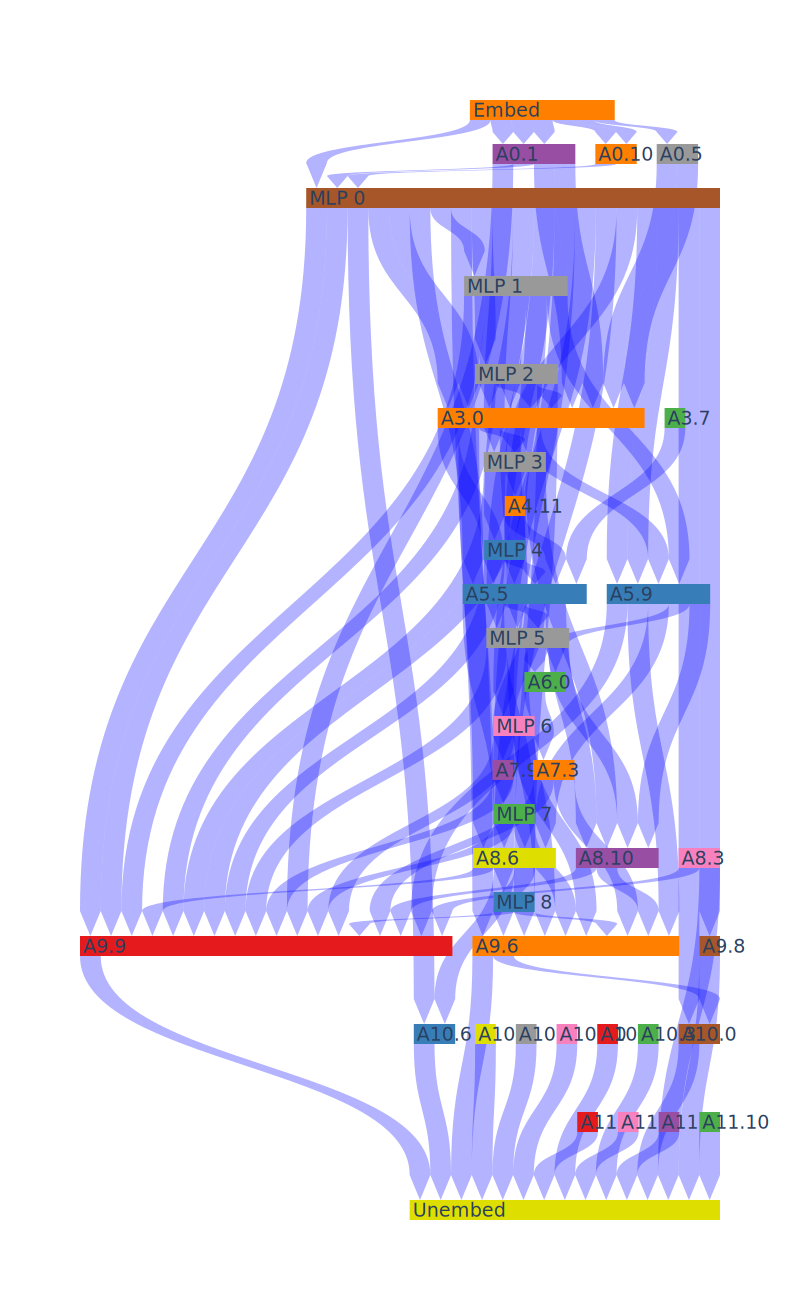

In [18]:
from src.circuit_discovery.auto_circuit import acdc_discovery, prepare_model_acdc
from pathlib import Path

results_key = 'acdc_ioi_edges'

patched_model = prepare_model_acdc(tl_model, device)

def test_model(patched_model, data_loader, save_path=None, score_threshold=0.03):
    total_edges, remaining_edges, pruned_scores = acdc_discovery(patched_model, data_loader, tau_bases=[score_threshold * 100])
    print(f"Total edges: {total_edges}")
    print(f"Remaining edges: {remaining_edges}")
    
    # Pruned neurons are given a value of inf
    # Interactive Image may cause performance issues
    if save_path:
        save_path = Path(save_path).resolve()

    _ = draw_seq_graph(patched_model, pruned_scores, score_threshold=score_threshold, orientation='v', layer_spacing='True', file_path=save_path)
    
    return remaining_edges, pruned_scores

regular_remaining_edges, regular_pruned_scores = test_model(patched_model, train_loader, save_path=None)

results = {results_key: regular_remaining_edges}